# Imports

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split

# Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [3]:
df_data = pd.read_csv('dataset\\full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Dataset Information

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

# Preparing Dataset
- Splitting Training Data into Training and Validation Sets. 

In [5]:
print(type(df_data['target'].iloc[0]))

<class 'str'>


In [6]:

# Splitting the dataset into training and validation sets
train_df, val_df = train_test_split(df_data, test_size=0.2, random_state=0)

# Function to load and preprocess images
def parse_image_and_label(image_path, label_string):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2) 
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return image, label

def load_and_prepare_dataset(csv_path, images_dir, shuffle=True, batch_size=32):
    df = pd.read_csv(csv_path)
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']
    labels = np.concatenate([df['target'].values, df['target'].values])
    
    filenames = np.concatenate([images_left, images_right])
    
    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_image_and_label, num_parallel_calls=tf.data.experimental.AUTOTUNE) 
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


# Creating training and validation datasets
train_ds = load_and_prepare_dataset('dataset\\full_df.csv', 'dataset\\ODIR-5K\\Training Images\\', shuffle=True, batch_size=32)
val_ds = load_and_prepare_dataset('dataset\\full_df.csv', 'dataset\\ODIR-5K\\Training Images\\', shuffle=False, batch_size=32)


In [7]:
print("size of training dataset: ", len(train_ds))
print("size of validation dataset: ", len(val_ds))

size of training dataset:  400
size of validation dataset:  400


# Visualising Training and Validation Data 

Training dataset


(32, 224, 224, 3)
(32, 8)


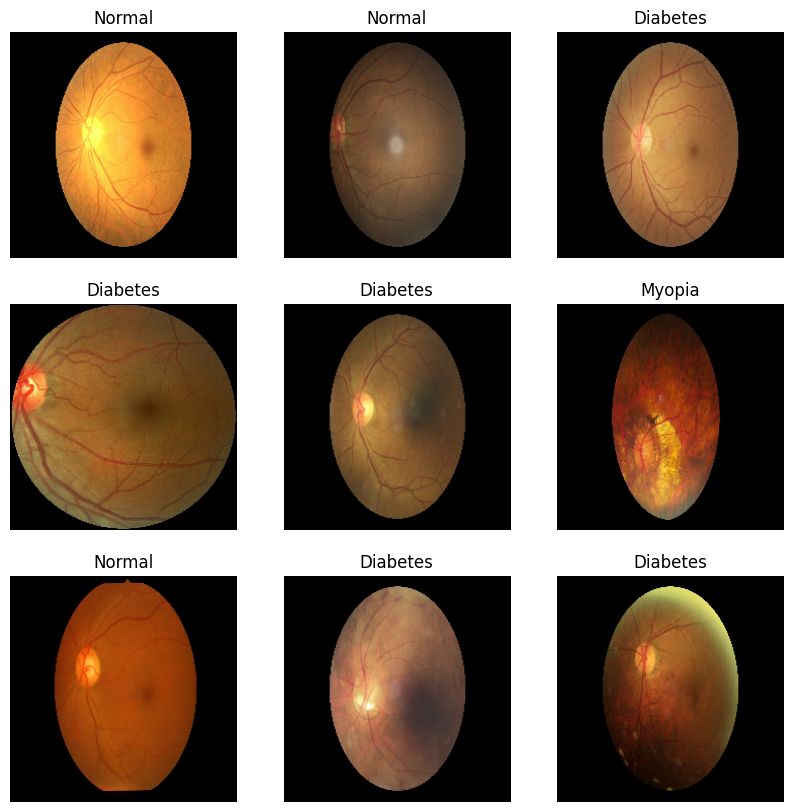

In [8]:
# Define your labels
string_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

print("Training dataset")
for images, numerical_labels in train_ds.take(1):
    print(images.shape)
    print(numerical_labels.shape)

    # Plotting the first 9 images with string labels
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Convert numerical label (one-hot encoded) to corresponding string label
        label_index = np.argmax(numerical_labels[i].numpy())  # Get the index of the max value in the one-hot encoded label
        plt.title(string_labels[label_index])
        
        plt.axis("off")
plt.show()

Validation dataset
(32, 224, 224, 3)
(32, 8)


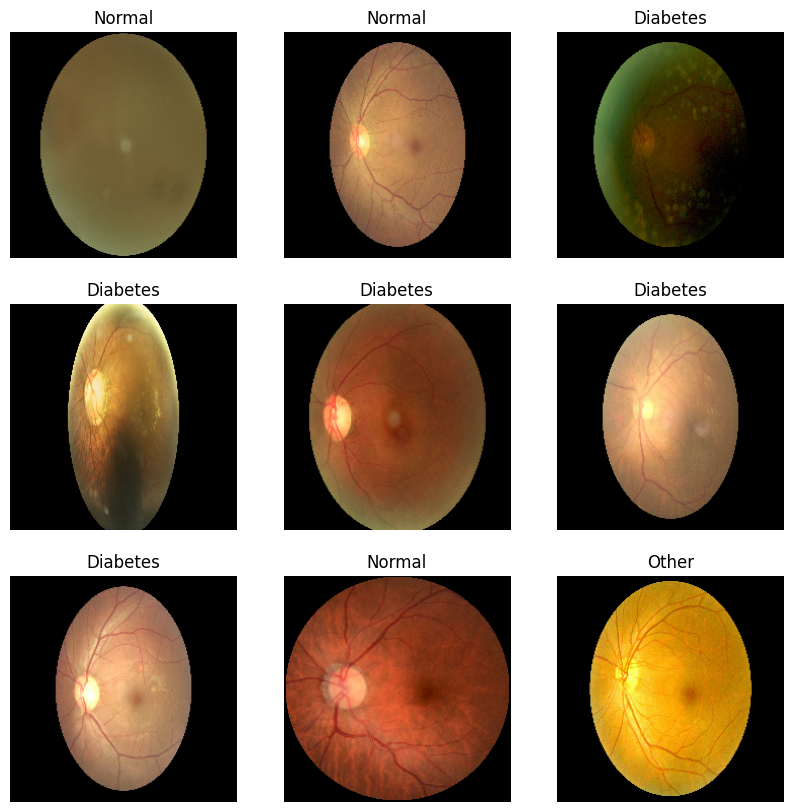

In [9]:
# Define your labels
string_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

print("Validation dataset")
for images, numerical_labels in val_ds.take(1):
    print(images.shape)
    print(numerical_labels.shape)

    # Plotting the first 9 images with string labels
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Convert numerical label (one-hot encoded) to corresponding string label
        label_index = np.argmax(numerical_labels[i].numpy())  # Get the index of the max value in the one-hot encoded label
        plt.title(string_labels[label_index])
        
        plt.axis("off")
plt.show()

# Training the model

In [10]:
resnet_50_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg', classes=8,
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_50_model.add(pretrained_model)
resnet_50_model.add(Flatten())
resnet_50_model.add(Dense(512, activation='relu'))
resnet_50_model.add(Dense(8, activation='softmax'))

In [11]:
resnet_50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,640,904
Trainable params: 1,053,192
Non-trainable params: 23,587,712
_________________________________________________________________


In [12]:
resnet_50_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
epochs = 10
history = resnet_50_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10


400/400 [==============================] - 135s 256ms/step - loss: 1.3386 - accuracy: 0.5038 - val_loss: 1.2487 - val_accuracy: 0.5462
Epoch 2/10
400/400 [==============================] - 129s 259ms/step - loss: 1.2079 - accuracy: 0.5460 - val_loss: 1.1542 - val_accuracy: 0.5632
Epoch 3/10
400/400 [==============================] - 127s 258ms/step - loss: 1.1590 - accuracy: 0.5580 - val_loss: 1.1014 - val_accuracy: 0.5839
Epoch 4/10
400/400 [==============================] - 126s 254ms/step - loss: 1.1240 - accuracy: 0.5735 - val_loss: 1.1047 - val_accuracy: 0.5735
Epoch 5/10
400/400 [==============================] - 121s 246ms/step - loss: 1.0915 - accuracy: 0.5851 - val_loss: 1.0596 - val_accuracy: 0.6105
Epoch 6/10
400/400 [==============================] - 115s 231ms/step - loss: 1.0503 - accuracy: 0.5928 - val_loss: 1.0093 - val_accuracy: 0.6157
Epoch 7/10
400/400 [==============================] - 112s 227ms/step - loss: 1.0123 - accuracy: 0.6094 - val_loss: 0.9852 - val_accura

# Evaluating Model 

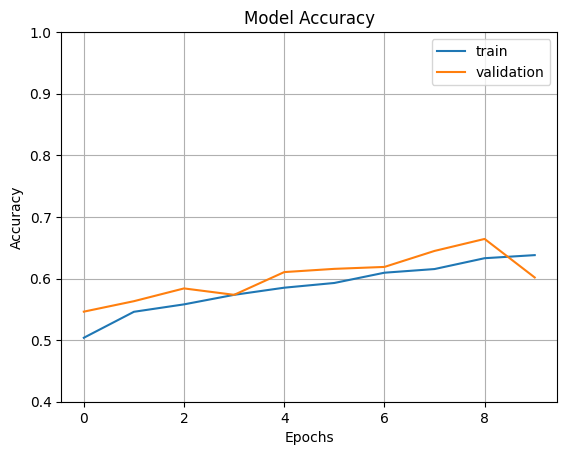

In [20]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

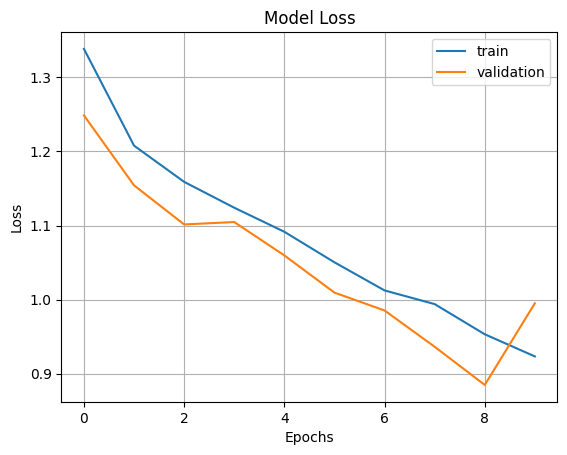

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Loading Test Data 

In [23]:
def parse_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    return image

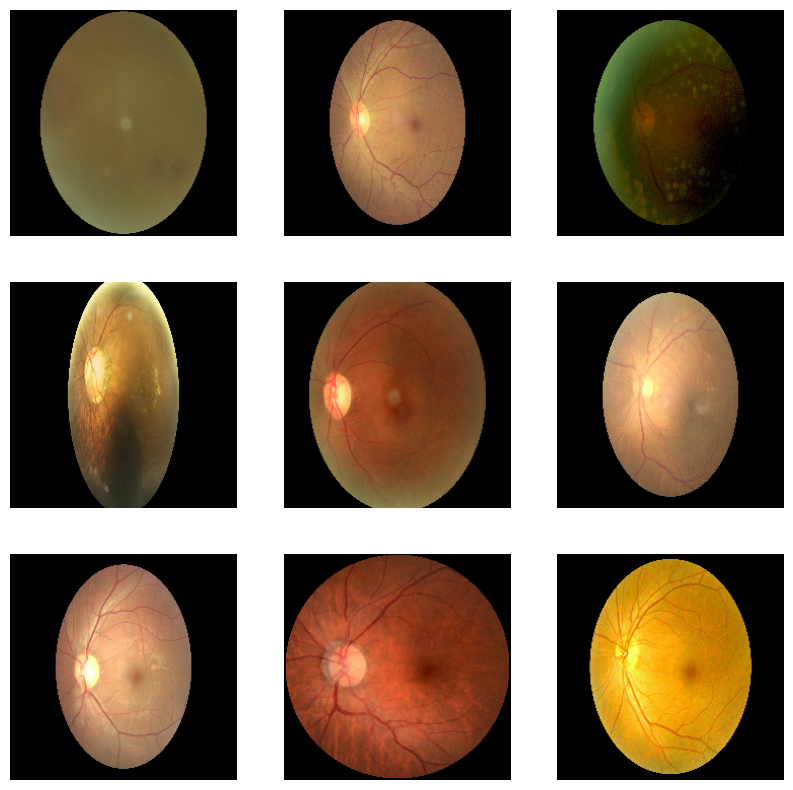

In [37]:
from pathlib import Path


data_dir = Path('dataset/ODIR-5K/')
test_dataset = list(data_dir.glob('Testing Images/*'))


test_dataset = [str(path) for path in test_dataset]
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
test_dataset = test_dataset.map(parse_image)


# Now you can batch, shuffle, and prefetch the dataset as needed
test_dataset = test_dataset.batch(32)  # batching
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)  # prefetching


# Visualize the data
plt.figure(figsize=(10,10))

for i, image in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis('off')



In [25]:
print("size of test dataset: ", len(test_dataset))    

size of test dataset:  32


# Making Predictions


32/32 [==============================] - 4s 122ms/step


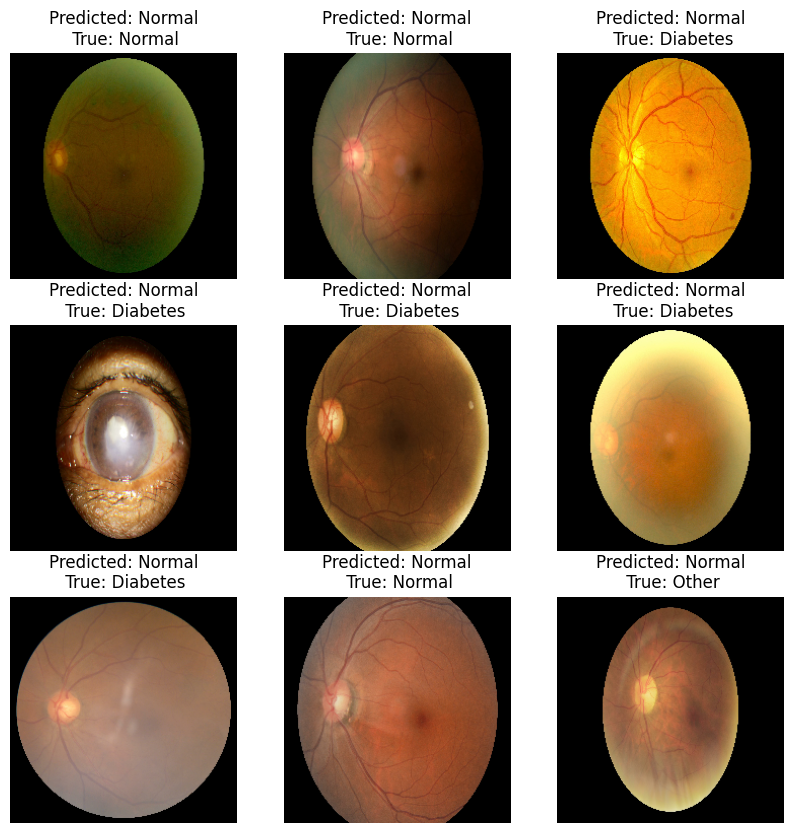

In [28]:
# Evaluate the model on the test dataset
resnet_50_model.evaluate(test_dataset)

predictions = resnet_50_model.predict(test_dataset)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']


# Plot the first 9 images, their predicted labels, and the true labels
output_class=class_labels[np.argmax(predicted_classes[i])]
plt.figure(figsize=(10, 10))

for i, image in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0] / 255)
    plt.title("Predicted: {}\n True: {}".format(output_class, class_labels[np.argmax(numerical_labels[i])]))
    plt.axis("off")

# Prediction Evaluation
- Classes normal, diabetes and others are the top 3 predicted classes, this suggests that the remaining classes are underrepresented hence the model is not using them to classify the test data.

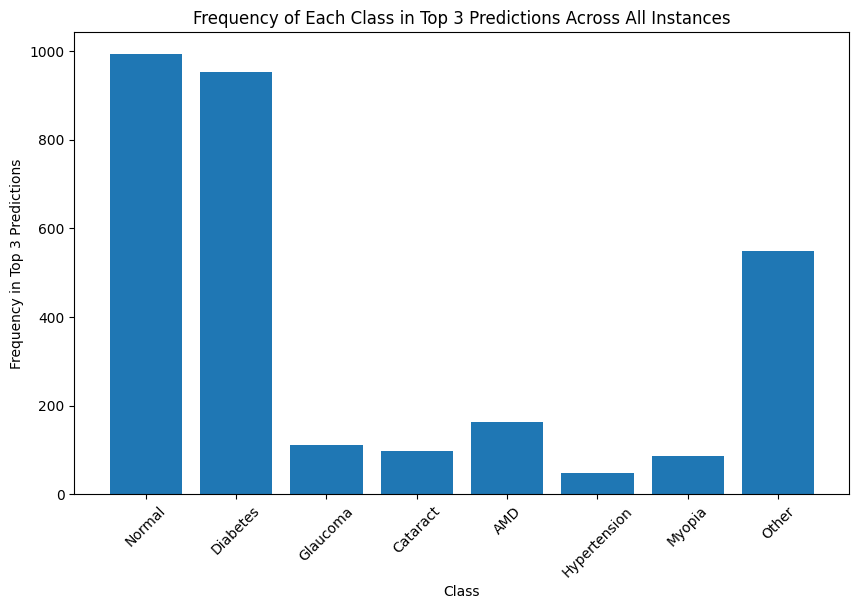

In [35]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1



# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [38]:
# Save the model
resnet_50_model.save('base-resnet_50_model')

INFO:tensorflow:Assets written to: base-resnet_50_model\assets


INFO:tensorflow:Assets written to: base-resnet_50_model\assets
